# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Learning Rate Decay](#Learning-Rate-Decay)

[Batch Normalization](#Batch-Normalization)

[Batch Generator](#Batch-Generator)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plot
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

/home/matheus1714/miniconda3/envs/mpdl/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

# Funções de Custo

###### Para Regressão

In [4]:
def mae(y, y_pred, derivative=False):
    if derivative:
        return np.where(y_pred>y, 1, -1)/y.shape[0]
    return np.mean((y-y_pred)**2)

def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y-y_pred)/y.shape[0]
    return 0.5 * np.mean((y-y_pred)**2)

###### Para Classificação Binária

In [5]:
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y-y_pred)/(y_pred*(1-y_pred)*y.shape[0])
    return np.mean(-1.0*y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y-y_sigmoid)/y.shape[0]
    return np.mean(-1.0*y*np.log(y_sigmoid) + (1-y)*np.log(1-y_sigmoid))

###### Para Classificação Multiclasse

In [6]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]    
    return neg_log_likelihood(y_oh, y_softmax)

# Inicialização de Pesos

In [7]:
def zeros(rows, cols):
    return np.zeros((rows, cols))

def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    std_dev = np.sqrt(2.0 / (rows + cols))
    return std_dev * np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    limit = np.sqrt(6.0 / (rows + cols))
    return 2.0 * limit * np.random.rand(rows, cols) - limit

# Regularização

In [8]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return np.array([np.where(w > 0, 1, w) for w in weights])
    return np.sum([np.sum(np.abs(w)) for w in weights])

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights**2)

# Batch Generator

In [9]:
def batch_sequential(x,y, batch_size=None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batches = x.shape[0]//batch_size
    
    for batch in range(n_batches):
        offset = batch_size - batch
        x_batch, y_batch = x[offset:offset + batch_size], y[offset:offset + batch_size]
        yield (x_batch, y_batch)
        
def batch_shuffle(x,y, batch_size=None):
    shuffle_index = np.random.permutation(range(x.shape[0]))
    return batch_sequential(x[shuffle_index], y[shuffle_index], batch_size)

# Learning Rate Decay

# Batch Normalization 

# Implementação 

In [10]:
class Layer():
    def __init__(
        self, 
        input_dim, 
        output_dim,
        weights_inicializer=random_normal, 
        biases_inicializer=ones, 
        activation=linear,
        dropout_prob=0.0,
        reg_func=l2_regularization,
        reg_strength=0.0
    ):
        self.input=None
        self.weights = weights_inicializer(output_dim, input_dim)
        self.biases = biases_inicializer(1, output_dim)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        
        self._activ_inp, self.activ_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        self._dropout_mask = None
        
class NeuralNetwork():
    
    def __init__(self, cost_func=mse, learning_rate=1e-3, momentum=0.0):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = learning_rate
        self.momentum = momentum
        
    def fit(self, x_train, y_train, epochs=100, verbose=10, batch_gen=batch_sequential, batch_size=None):
        for epoch in range(epochs+1):
            for x_batch, y_batch in batch_gen(x_train, y_train, batch_size):
                y_pred = self.__feadforward(x_batch)
                self.__backprop(y_batch, y_pred)
            
            if epoch % verbose == 0:
                loss_train = self.cost_func(y_train, self.predict(x_train))
                loss_reg = (1.0/(y_train.shape[0]))* np.sum([layer.reg_strength * layer.reg_func(layer.weights) for layer in self.layers])
                
                print('epoch: {0:=4}/{1} loss_train: {2:.8f}'.format(epoch, epochs, loss_train))

    def predict(self, x):
        return self.__feadforward(x, is_training=False)
    
    def __feadforward(self, x, is_training=True):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0,0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            
            current_layer._dropout_mask = np.random.binomial(1, 1 - current_layer.dropout_prob, y.shape) / (1 - current_layer.dropout_prob)
            current_layer._activ_inp = y
            current_layer._activ_out = current_layer.activation(y) * (current_layer._dropout_mask if is_training else 1.0)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out
            
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta * layer._dropout_mask
            last_delta = np.dot(dactivation, layer.weights)
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0 * dactivation.sum(axis = 0, keepdims = True)
            
        for layer in reversed(self.layers):
            layer._dweights = layer._dweights + (1.0/(y.shape[0])*layer.reg_strength*layer.reg_func(layer.weights, derivative=True))
            layer._prev_dweights = - self.learning_rate * layer._dweights + self.momentum * layer._prev_dweights
            layer.weights += layer._prev_dweights
            layer.biases -= self.learning_rate * layer._dbiases

## Exemplos do Notebook da Intuição

### Exemplo 1

In [75]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35, 0.35]]) 
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60, 0.60]])

# insira sua rede aqui!

input_dim, output_dim = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim=input_dim, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=output_dim, activation=sigmoid))

nn.layers[0].weights = w1
nn.layers[0].biases = b1

nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs=0, verbose=1)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/0 loss_train: 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]


### Exemplo 2

In [76]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

# insira sua rede aqui!

nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b

nn.fit(x, y, epochs=300, verbose=30)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/300 loss_train: 1.53551006
epoch:   30/300 loss_train: 0.00000000
epoch:   60/300 loss_train: 0.00000000
epoch:   90/300 loss_train: 0.00000000
epoch:  120/300 loss_train: 0.00000000
epoch:  150/300 loss_train: 0.00000000
epoch:  180/300 loss_train: 0.00000000
epoch:  210/300 loss_train: 0.00000000
epoch:  240/300 loss_train: 0.00000000
epoch:  270/300 loss_train: 0.00000000
epoch:  300/300 loss_train: 0.00000000
[[0.08599119 0.17198239 0.20193836]
 [0.2831936  0.1663872  0.58235521]
 [0.36625019 0.23250038 0.66375134]]
[[-0.24202794 -0.24962245 -0.07843328]
 [ 0.06072265  0.2026165   0.38864709]
 [ 0.42518878  0.18309756  0.57246228]]
[[-0.19590947  0.059025    0.44852885]
 [-0.21146954  0.11017881 -0.40794853]
 [-0.09637542 -0.48684846  0.19212956]]


## Gradient Checking

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

(100, 2)
(100, 1) (100, 1)


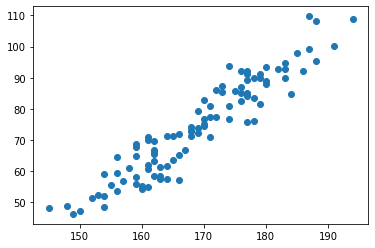

In [77]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)
plt.scatter(x, y)

-1.0 0.9999999999999991


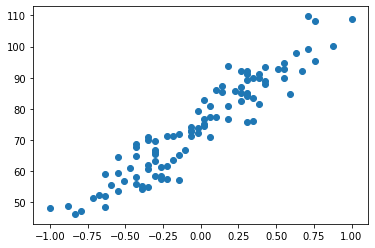

In [78]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())
plt.scatter(x, y)

epoch:    0/20000 loss_train: 2289.47861279
epoch: 1000/20000 loss_train: 13.04145724
epoch: 2000/20000 loss_train: 13.04145724
epoch: 3000/20000 loss_train: 13.04145724
epoch: 4000/20000 loss_train: 13.04145724
epoch: 5000/20000 loss_train: 13.04145724
epoch: 6000/20000 loss_train: 13.04145724
epoch: 7000/20000 loss_train: 13.04145724
epoch: 8000/20000 loss_train: 13.04145724
epoch: 9000/20000 loss_train: 13.04145724
epoch: 10000/20000 loss_train: 13.04145724
epoch: 11000/20000 loss_train: 13.04145724
epoch: 12000/20000 loss_train: 13.04145724
epoch: 13000/20000 loss_train: 13.04145724
epoch: 14000/20000 loss_train: 13.04145724
epoch: 15000/20000 loss_train: 13.04145724
epoch: 16000/20000 loss_train: 13.04145724
epoch: 17000/20000 loss_train: 13.04145724
epoch: 18000/20000 loss_train: 13.04145724
epoch: 19000/20000 loss_train: 13.04145724
epoch: 20000/20000 loss_train: 13.04145724
[[33.60164767]]


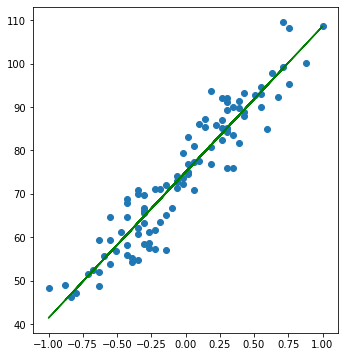

In [79]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))
nn.fit(x, y, epochs=20000, verbose=1000)

for layer in nn.layers:
    print(layer.weights)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [80]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


[-1. -1. -1.] [1. 1. 1.]


ValueError: x and y must be the same size

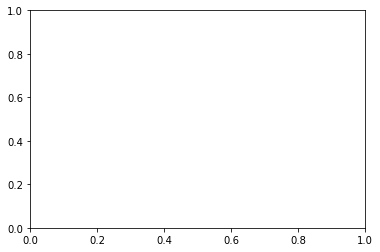

In [81]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))
plt.scatter(x, y)

In [ ]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

### Regressão Quadrática

In [ ]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [ ]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

In [ ]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=5000, verbose=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

In [ ]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [82]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [1. 1. 1.]


epoch:    0/5000 loss_train: 2297.31577146
epoch:  500/5000 loss_train: 3.57164500
epoch: 1000/5000 loss_train: 24.13780724
epoch: 1500/5000 loss_train: 3.36298294
epoch: 2000/5000 loss_train: 2.01272352
epoch: 2500/5000 loss_train: 3.89082411
epoch: 3000/5000 loss_train: 2.20343265
epoch: 3500/5000 loss_train: 36.73238193
epoch: 4000/5000 loss_train: 3.13578675
epoch: 4500/5000 loss_train: 4.65920118
epoch: 5000/5000 loss_train: 2.14538362


ValueError: x and y must be the same size

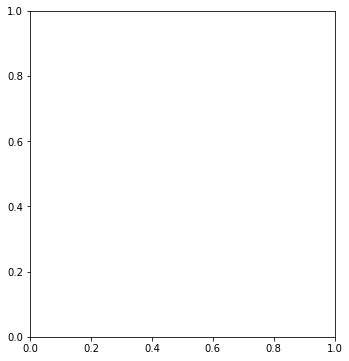

In [83]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=50, activation=relu, dropout_prob=0.1))
nn.layers.append(Layer(input_dim=50, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=5000, verbose=500)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

(100, 1) (100, 1)


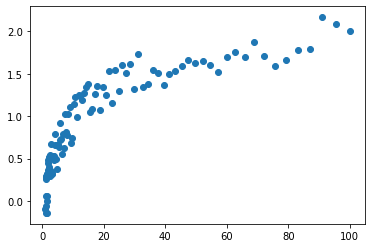

In [84]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [85]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000 loss_train: 0.19244222
epoch:  500/5000 loss_train: 0.09784883
epoch: 1000/5000 loss_train: 0.05654318
epoch: 1500/5000 loss_train: 0.03992519
epoch: 2000/5000 loss_train: 0.03336015
epoch: 2500/5000 loss_train: 0.03054039
epoch: 3000/5000 loss_train: 0.02905494
epoch: 3500/5000 loss_train: 0.02805098
epoch: 4000/5000 loss_train: 0.02724226
epoch: 4500/5000 loss_train: 0.02653372
epoch: 5000/5000 loss_train: 0.02589154


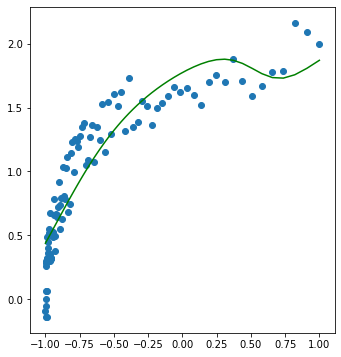

In [87]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear))
nn.fit(x, y, epochs=5000, verbose=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

(100, 1) (100, 1)


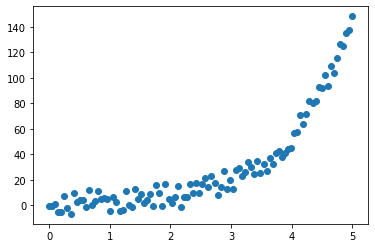

In [31]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [32]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000 loss_train: 1230.48041375
epoch:  500/5000 loss_train: 75.99022009
epoch: 1000/5000 loss_train: 31.63552592
epoch: 1500/5000 loss_train: 21.64478991
epoch: 2000/5000 loss_train: 17.66136100
epoch: 2500/5000 loss_train: 15.65424315
epoch: 3000/5000 loss_train: 14.54660257
epoch: 3500/5000 loss_train: 13.90280138
epoch: 4000/5000 loss_train: 13.50665532
epoch: 4500/5000 loss_train: 13.24910654
epoch: 5000/5000 loss_train: 13.07482576


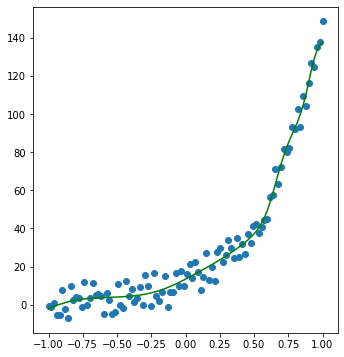

In [33]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))
nn.fit(x, y, epochs=5000, verbose=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

(4, 2) (4, 1)


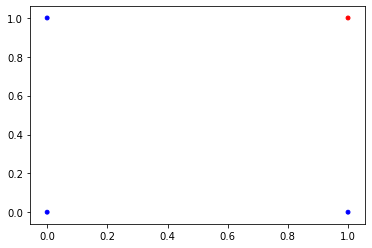

In [34]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: -1.07654150
epoch:  100/1000 loss_train: -0.02188794
epoch:  200/1000 loss_train: -0.01320059
epoch:  300/1000 loss_train: -0.00937331
epoch:  400/1000 loss_train: -0.00723849
epoch:  500/1000 loss_train: -0.00588363
epoch:  600/1000 loss_train: -0.00495006
epoch:  700/1000 loss_train: -0.00426894
epoch:  800/1000 loss_train: -0.00375070
epoch:  900/1000 loss_train: -0.00334347
epoch: 1000/1000 loss_train: -0.00301524
Predições:
[[1.21730544e-05]
 [2.00919394e-02]
 [2.00919352e-02]
 [9.71859276e-01]]
Acurácia: 100.00%


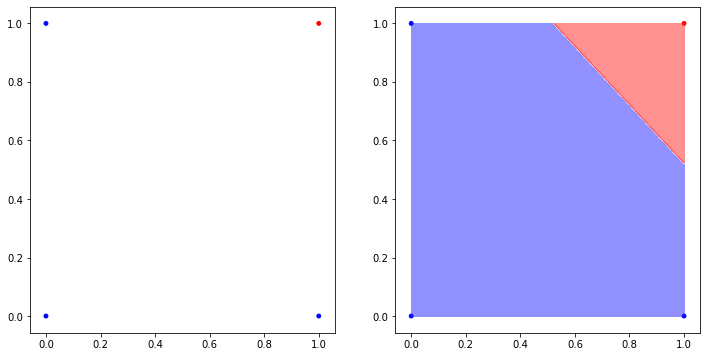

In [35]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=sigmoid))
nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, threshold=0.5, nn=nn, cmap='bwr')

### Porta XOR

(4, 2) (4, 1)


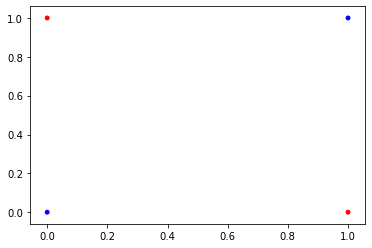

In [36]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: -0.05658260
epoch:  100/1000 loss_train: 0.01587840
epoch:  200/1000 loss_train: 0.03883822
epoch:  300/1000 loss_train: 0.05156865
epoch:  400/1000 loss_train: 0.01490880
epoch:  500/1000 loss_train: 0.00406040
epoch:  600/1000 loss_train: 0.00333890
epoch:  700/1000 loss_train: 0.00263570
epoch:  800/1000 loss_train: 0.00213754
epoch:  900/1000 loss_train: 0.00178541
epoch: 1000/1000 loss_train: 0.00152785
Predições:
[[0.01607077]
 [0.97984745]
 [0.98423468]
 [0.01383992]]
Acurácia: 100.00%


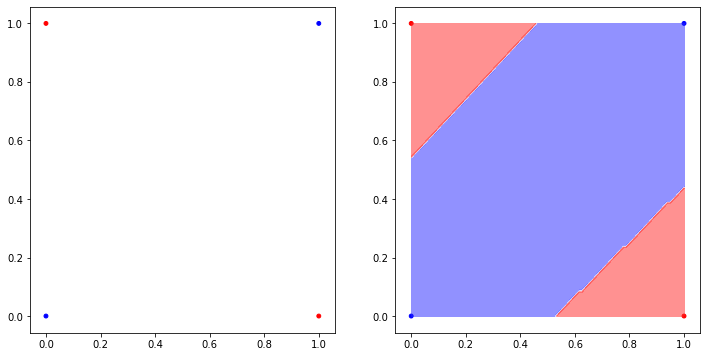

In [39]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=input_dim, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=output_dim, activation=sigmoid))
nn.fit(x, y, epochs=1000, verbose=100)


y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, threshold=0.5, nn=nn, cmap='bwr')

### 2 Clusters

(100, 2) (100, 1)


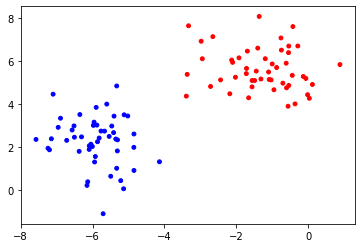

In [40]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000 loss_train: 3.02252337
epoch: 1000/5000 loss_train: 0.00063725
epoch: 2000/5000 loss_train: 0.00045251
epoch: 3000/5000 loss_train: 0.00036902
epoch: 4000/5000 loss_train: 0.00031817
epoch: 5000/5000 loss_train: 0.00028279
Acurácia: 100.00%


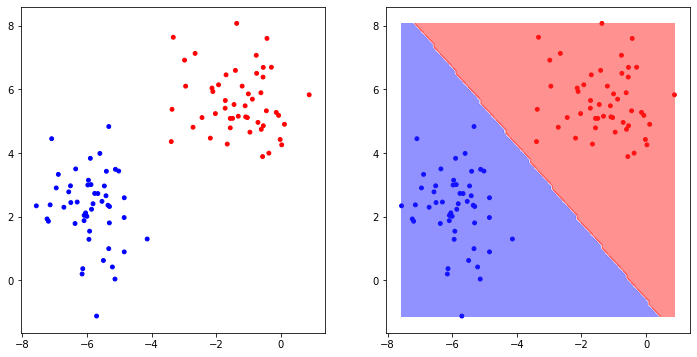

In [41]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=0.1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=sigmoid))
nn.fit(x, y, epochs=5000, verbose=1000)


y_pred = nn.predict(x)

threshold = 0 if nn.layers[-1].activation == linear else 0.5
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= threshold)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

(500, 2) (500, 1)


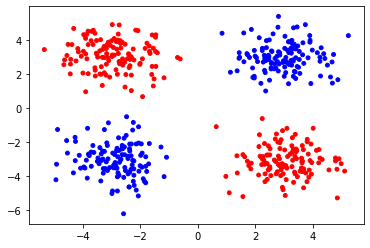

In [42]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 lose_train: 0.15157509
epoch:  100/1000 lose_train: 0.05322664
epoch:  200/1000 lose_train: 0.00959766
epoch:  300/1000 lose_train: 0.00455259
epoch:  400/1000 lose_train: 0.00294286
epoch:  500/1000 lose_train: 0.00215237
epoch:  600/1000 lose_train: 0.00168553
epoch:  700/1000 lose_train: 0.00136987
epoch:  800/1000 lose_train: 0.00114539
epoch:  900/1000 lose_train: 0.00098271
epoch: 1000/1000 lose_train: 0.00085828
Acurácia: 100.00%


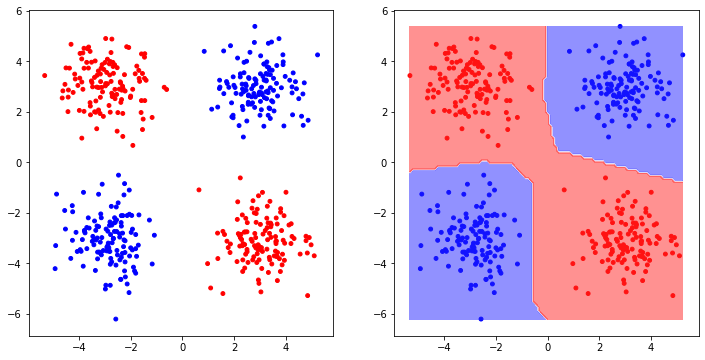

In [219]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=0.1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=output_dim, activation=sigmoid))
nn.fit(x, y, epochs=1000, verbose=100)


y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

(500, 2) (500, 1)


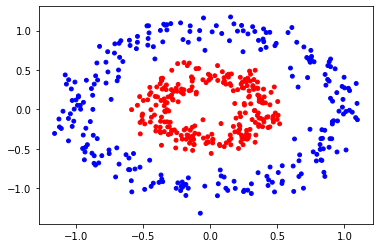

In [43]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: -0.62926929
epoch:  100/1000 loss_train: 0.00089332
epoch:  200/1000 loss_train: 0.00017205
epoch:  300/1000 loss_train: 0.00000223
epoch:  400/1000 loss_train: -0.00003859
epoch:  500/1000 loss_train: -0.00003339
epoch:  600/1000 loss_train: -0.00001502
epoch:  700/1000 loss_train: 0.00001110
epoch:  800/1000 loss_train: 0.00003032
epoch:  900/1000 loss_train: 0.00004350
epoch: 1000/1000 loss_train: 0.00005525
Acurácia: 100.00%


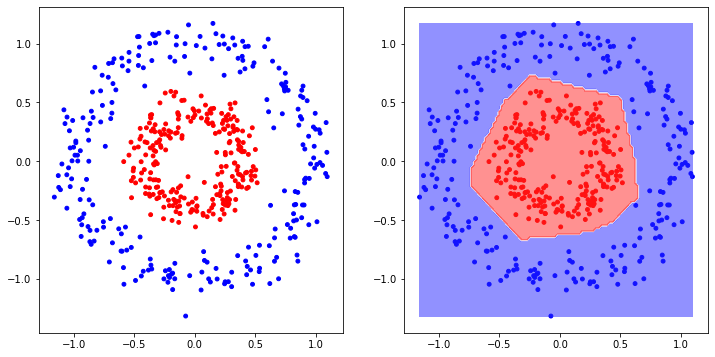

In [44]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=0.1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=output_dim, activation=sigmoid))
nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

(200, 2) (200, 1)


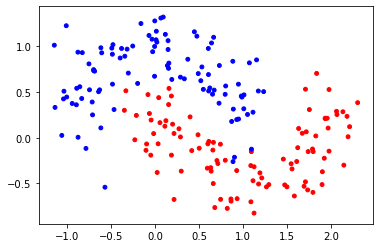

In [45]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: -0.28575090
epoch:  100/1000 loss_train: -0.00065598
epoch:  200/1000 loss_train: -0.00730342
epoch:  300/1000 loss_train: -0.01017633
epoch:  400/1000 loss_train: -0.01125607
epoch:  500/1000 loss_train: -0.01157634
epoch:  600/1000 loss_train: -0.01157108
epoch:  700/1000 loss_train: -0.01142748
epoch:  800/1000 loss_train: -0.01123125
epoch:  900/1000 loss_train: -0.01102276
epoch: 1000/1000 loss_train: -0.01082047
Acurácia: 90.50%


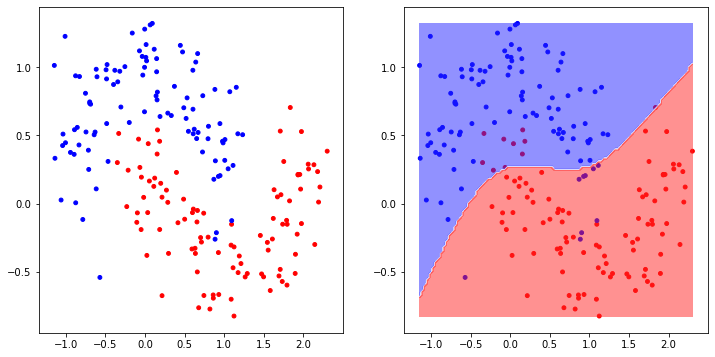

In [46]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=0.1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=8, activation=tanh, reg_strength=2.0, reg_func=l2_regularization))
nn.layers.append(Layer(input_dim=8, output_dim=output_dim, activation=sigmoid, reg_strength=2.0, reg_func=l2_regularization))
nn.fit(x, y, epochs=1000, verbose=100)


y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

(200, 2) (200, 1)


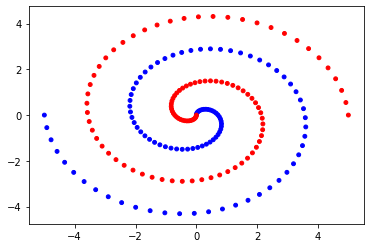

In [47]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/10000 loss_train: -0.47418947
epoch: 1000/10000 loss_train: 0.00545302
epoch: 2000/10000 loss_train: 0.00765500
epoch: 3000/10000 loss_train: 0.00600804
epoch: 4000/10000 loss_train: 0.00549611
epoch: 5000/10000 loss_train: 0.00501432
epoch: 6000/10000 loss_train: 0.00461236
epoch: 7000/10000 loss_train: 0.00433733
epoch: 8000/10000 loss_train: 0.00413602
epoch: 9000/10000 loss_train: 0.00395409
epoch: 10000/10000 loss_train: 0.00378581
Acurácia: 99.50%


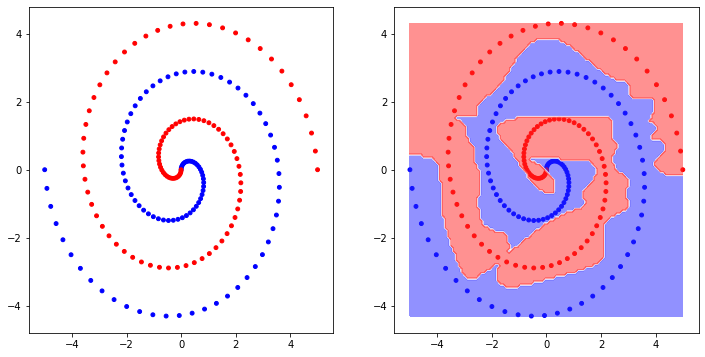

In [49]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=0.1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=output_dim, activation=sigmoid))
nn.fit(x, y, epochs=10000, verbose=1000)


y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

(300, 2) (300, 1)


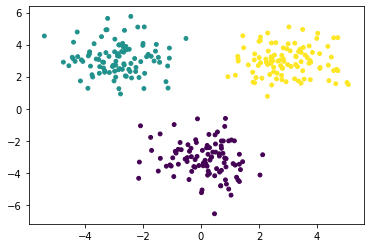

In [50]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [51]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


epoch:    0/1000 loss_train: 2.76765633
epoch:  100/1000 loss_train: 0.08615459
epoch:  200/1000 loss_train: 0.04274729
epoch:  300/1000 loss_train: 0.02845474
epoch:  400/1000 loss_train: 0.02131988
epoch:  500/1000 loss_train: 0.01704729
epoch:  600/1000 loss_train: 0.01419899
epoch:  700/1000 loss_train: 0.01216479
epoch:  800/1000 loss_train: 0.01063868
epoch:  900/1000 loss_train: 0.00945139
epoch: 1000/1000 loss_train: 0.00850137
Acurácia: 100.00%


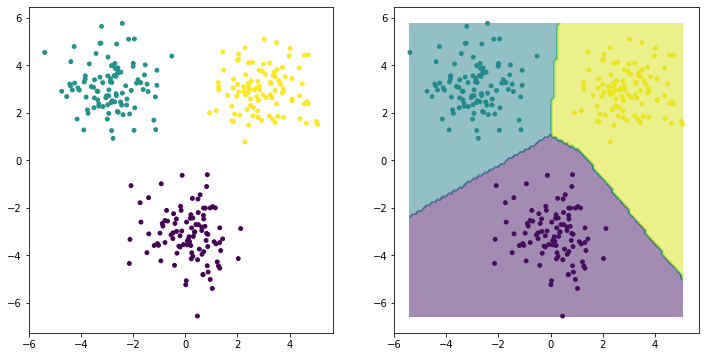

In [52]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, epochs=1000, verbose=100)

    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

(400, 2) (400, 1)


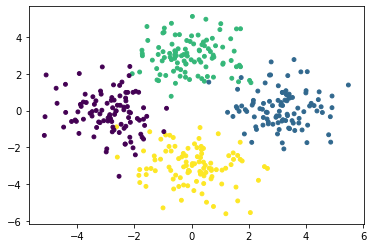

In [53]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [54]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


epoch:    0/1000 loss_train: 3.03362616
epoch:  100/1000 loss_train: 0.23164116
epoch:  200/1000 loss_train: 0.15299879
epoch:  300/1000 loss_train: 0.12367165
epoch:  400/1000 loss_train: 0.10908022
epoch:  500/1000 loss_train: 0.10055159
epoch:  600/1000 loss_train: 0.09495555
epoch:  700/1000 loss_train: 0.09103303
epoch:  800/1000 loss_train: 0.08809956
epoch:  900/1000 loss_train: 0.08581530
epoch: 1000/1000 loss_train: 0.08398262
Acurácia: 97.50%


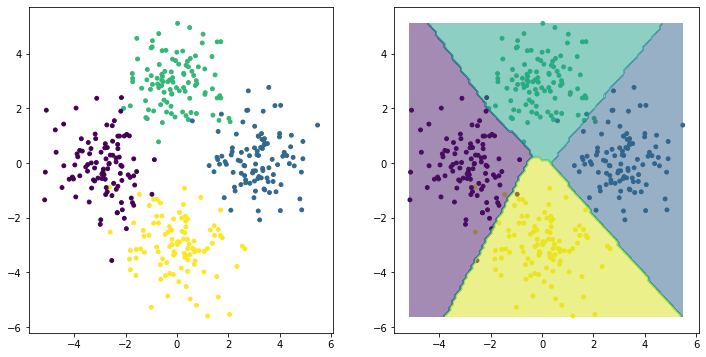

In [55]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

(500, 2) (500, 1)


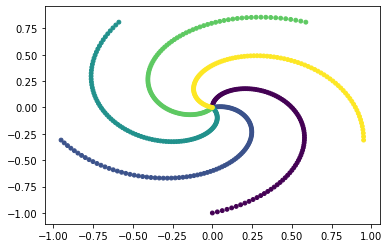

In [56]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [57]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


epoch:    0/10000 loss_train: 2.23086993
epoch: 1000/10000 loss_train: 0.60327492
epoch: 2000/10000 loss_train: 0.36036685
epoch: 3000/10000 loss_train: 0.21064907
epoch: 4000/10000 loss_train: 0.13933969
epoch: 5000/10000 loss_train: 0.10817237
epoch: 6000/10000 loss_train: 0.09073081
epoch: 7000/10000 loss_train: 0.07923053
epoch: 8000/10000 loss_train: 0.07093574
epoch: 9000/10000 loss_train: 0.06460355
epoch: 10000/10000 loss_train: 0.05957533
Acurácia: 99.00%


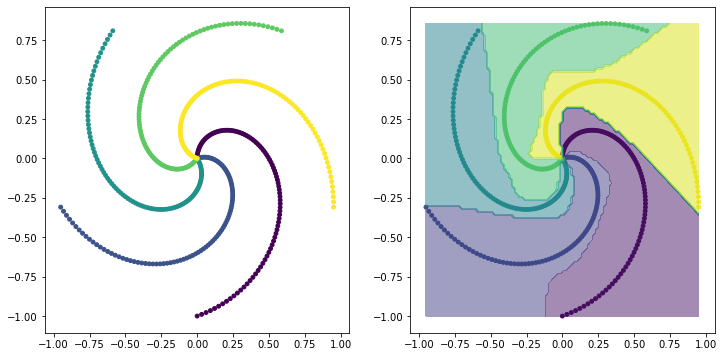

In [58]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=5, activation=tanh))
nn.layers.append(Layer(input_dim=5, output_dim=5, activation=tanh))
nn.layers.append(Layer(input_dim=5, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, epochs=10000, verbose=1000)


y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

(100, 2) (100, 1)


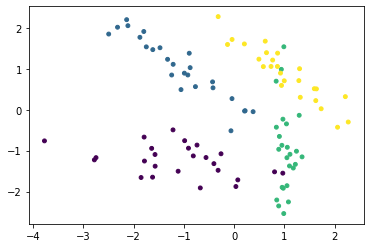

In [59]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [60]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


epoch:    0/1000 loss_train: 1.62490946
epoch:  100/1000 loss_train: 0.36413402
epoch:  200/1000 loss_train: 0.25981538
epoch:  300/1000 loss_train: 0.22740742
epoch:  400/1000 loss_train: 0.21093117
epoch:  500/1000 loss_train: 0.20041114
epoch:  600/1000 loss_train: 0.19266301
epoch:  700/1000 loss_train: 0.18641354
epoch:  800/1000 loss_train: 0.18106631
epoch:  900/1000 loss_train: 0.17631213
epoch: 1000/1000 loss_train: 0.17198748
Acurácia: 95.00%


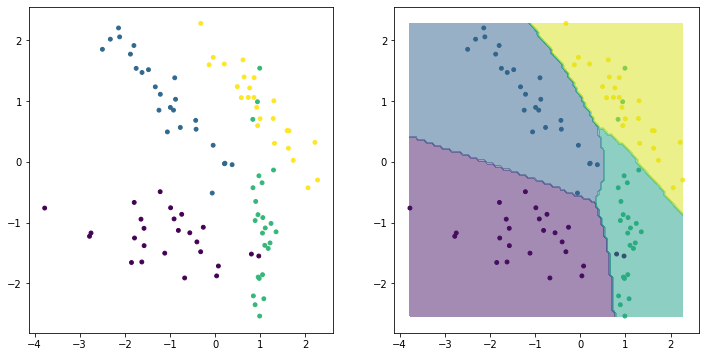

In [61]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=5, activation=tanh))
nn.layers.append(Layer(input_dim=5, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Iris Dataset

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


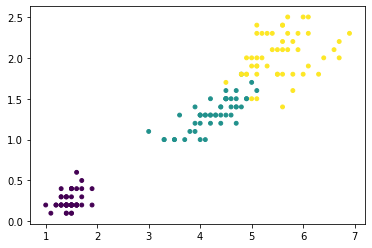

In [11]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [12]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


epoch:    0/1000 loss_train: 1.55475504
epoch:  100/1000 loss_train: 0.15266156
epoch:  200/1000 loss_train: 0.09609445
epoch:  300/1000 loss_train: 0.09173613
epoch:  400/1000 loss_train: 0.08223823
epoch:  500/1000 loss_train: 0.07949686
epoch:  600/1000 loss_train: 0.08934809
epoch:  700/1000 loss_train: 0.24044259
epoch:  800/1000 loss_train: 0.11061364
epoch:  900/1000 loss_train: 0.12361653
epoch: 1000/1000 loss_train: 0.10183311
Acurácia: 96.00%


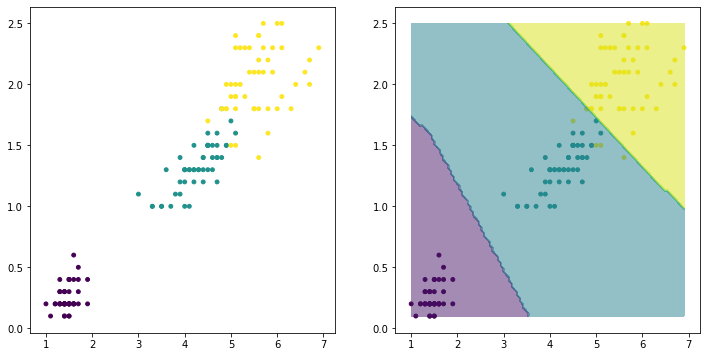

In [13]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, epochs=1000, verbose=100, batch_gen=batch_shuffle, batch_size=15)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

# [Link para o Questionário](https://docs.google.com/forms/d/e/1FAIpQLSf1B3JKsPPPc1oYD_3FyX4UvNLpcXnTW2I177A_WE0_B56Elw/viewform?usp=sf_link)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__Regularization__:
- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)
- [Implementing Neural Network L2 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/29/implementing-neural-network-l2-regularization/)
- [Neural Network L2 Regularization Using Python](https://visualstudiomagazine.com/articles/2017/09/01/neural-network-l2.aspx)

__Momentum__:
- [Neural Network Momentum Using Python](https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx)
- [Beyond SGD: Gradient Descent with Momentum and Adaptive Learning Rate](https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/)

__Learning Rate Decay__:
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
- [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- [Tensorflow Exponential Decay Documentation](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

__Batch Normalization__:
- [Understanding the backward pass through Batch Normalization Layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
- [Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)
- [Implementing BatchNorm in Neural Net](https://wiseodd.github.io/techblog/2016/07/04/batchnorm/)
- [What does the gradient flowing through batch normalization looks like ?](http://cthorey.github.io./backpropagation/)
- [GRADIENTS, BATCH NORMALIZATION AND LAYER NORMALIZATION](https://theneuralperspective.com/2016/10/27/gradient-topics/)

__Gradient Checking__:
- [cs231n](https://github.com/cs231n/cs231n.github.io/blob/master/neural-networks-3.md#gradcheck)
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization)
- [BatchNormalization fails gradient checking](https://github.com/torch/nn/issues/744)